# Resnet50 적용하기
## Model 정의

### residual_block 정의

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def residual_block(input_tensor, kernel_size, num_filters, naming):
    x = Conv2D(kernel_size=(1, 1), filters = num_filters//4, kernel_initializer = 'he_normal', name='Conv_' + naming + '_a')(input_tensor)
    x = BatchNormalization(name = 'BN_' + naming + '_a')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size = kernel_size, padding='same', kernel_initializer = 'he_normal', filters = num_filters//4, name='Conv_' + naming + '_b')(x)
    x = BatchNormalization(name = 'BN_' + naming + '_b')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size = (1, 1), filters = num_filters, kernel_initializer = 'he_normal', name='Conv_' + naming + '_c')(x)
    x = BatchNormalization(name = 'BN_' + naming + '_c')(x)
    x = Add()([input_tensor, x])

    x = Activation('relu')(x)

    return x

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

input_tensor = Input(shape=(56, 56, 256))  # 내 데이터에 맞게 수정
output_tensor = residual_block(input_tensor, kernel_size=(3, 3), num_filters=256, naming='block1')

model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 56, 56, 256)]        0         []                            
                                                                                                  
 Conv_block1_a (Conv2D)      (None, 56, 56, 64)           16448     ['input_3[0][0]']             
                                                                                                  
 BN_block1_a (BatchNormaliz  (None, 56, 56, 64)           256       ['Conv_block1_a[0][0]']       
 ation)                                                                                           
                                                                                                  
 activation_6 (Activation)   (None, 56, 56, 64)           0         ['BN_block1_a[0][0]']     

### downsize_block 정의

In [11]:
def downsize_block(input_tensor, kernel_size, strides, num_filters, naming):
    x = Conv2D(kernel_size= (1, 1), filters= num_filters//4, strides= strides, kernel_initializer= 'he_normal', name= 'Conv_' + naming + '_a')(input_tensor)
    x = BatchNormalization(name= 'BN_' + naming + '_a')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size= kernel_size, filters= num_filters//4, padding= 'same', kernel_initializer= 'he_normal', name= 'Conv_' + naming + '_b')(x)
    x = BatchNormalization(name= 'BN_' + naming + '_b')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size= (1, 1), filters= num_filters, kernel_initializer= 'he_normal', name= 'Conv_' + naming + '_c')(x)
    x = BatchNormalization(name= 'BN' + naming + '_c')(x)

    shortcut = Conv2D(kernel_size= (1, 1), filters= num_filters, strides= strides, kernel_initializer= 'he_normal', name= 'SC_' + naming)(input_tensor)
    shortcut = BatchNormalization(name= 'SC_BN_' + naming)(shortcut)

    x = Add()([shortcut, x])
    output_tensor = Activation('relu')(x)

    return output_tensor

In [12]:
import tensorflow.keras as ks

input_tensor = ks.layers.Input(shape=(56, 56, 256))  # 내 데이터에 맞게 수정
output_tensor = downsize_block(input_tensor, kernel_size=(3, 3), strides=(2, 2), num_filters=512, naming='block2')

model = ks.models.Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 56, 56, 256)]        0         []                            
                                                                                                  
 Conv_block2_a (Conv2D)      (None, 28, 28, 128)          32896     ['input_8[0][0]']             
                                                                                                  
 BN_block2_a (BatchNormaliz  (None, 28, 28, 128)          512       ['Conv_block2_a[0][0]']       
 ation)                                                                                           
                                                                                                  
 activation_67 (Activation)  (None, 28, 28, 128)          0         ['BN_block2_a[0][0]']   

In [13]:
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, GlobalMaxPooling2D, Dense

input_tensor = Input(shape=(224, 224, 3))

def first_convolution(input_tensor):
  x = ZeroPadding2D(padding=(3, 3))(input_tensor)
  x = Conv2D(filters=64, strides=(2, 2), kernel_size=(7, 7), kernel_initializer='he_normal')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)

  return x

def first_pooling(input_tensor):
  x = ZeroPadding2D(padding=(1, 1))(input_tensor)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

  return x

# 첫번째 stage, convolution 수행, strides = 2로 하여 크기를 반으로
x = first_convolution(input_tensor)

# 두번째 stage, pooling을 적용하여 크기를 반으로 줄이고, 첫번째 downsize block에서는 strides = 1로 하여 크기를 유지
x = first_pooling(x)
x = downsize_block(x, kernel_size=(3, 3), strides=(1, 1), num_filters=256, naming='s2d1')
x = residual_block(x, kernel_size=(3, 3), num_filters=256, naming='s2r1')
x = residual_block(x, kernel_size=(3, 3), num_filters=256, naming='s2r2')

# 세번째 stage, block의 수는 4개
x = downsize_block(x, kernel_size=(3, 3), strides=(2, 2), num_filters=512, naming='s3d')
x = residual_block(x, kernel_size=(3, 3), num_filters=512, naming='s3r1')
x = residual_block(x, kernel_size=(3, 3), num_filters=512, naming='s3r2')
x = residual_block(x, kernel_size=(3, 3), num_filters=512, naming='s3r3')
x = residual_block(x, kernel_size=(3, 3), num_filters=512, naming='s3r4')

#네번째 stage, block 의 수는 6개
x = downsize_block(x, (3, 3), (2, 2), 1024, 's4d')
x = residual_block(x, (3, 3), 1024, 's4r1')
x = residual_block(x, (3, 3), 1024, 's4r2')
x = residual_block(x, (3, 3), 1024, 's4r3')
x = residual_block(x, (3, 3), 1024, 's4r4')
x = residual_block(x, (3, 3), 1024, 's4r5')

#다섯번째 stage, block 의 수는 3개
x = downsize_block(x, (3, 3), (2, 2), 2048, 's5d')
x = residual_block(x, (3, 3), 2048, 's5d1')
x = residual_block(x, (3, 3), 2048, 's5d2')

#Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
x = GlobalMaxPooling2D()(x)
x = Dense(10, activation= 'softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

In [14]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_9[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         9472      ['zero_padding2d_2[0][0]']    
                                                                                                  
 batch_normalization_1 (Bat  (None, 112, 112, 64)         256       ['conv2d_1[0][0]']      

## 이미지 불러오기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


In [17]:
import pathlib

data_path = './Traffic_light_kr-1/train/images'
data_dir = pathlib.Path(data_path)
image_count = len(list(data_dir.glob('*.jpg')))   # train 폴더 내의 이미지 개수
print(image_count)

264


sample image를 보자.  
이 이미지는 사전에 학습을 위해 duplicated된 image다.

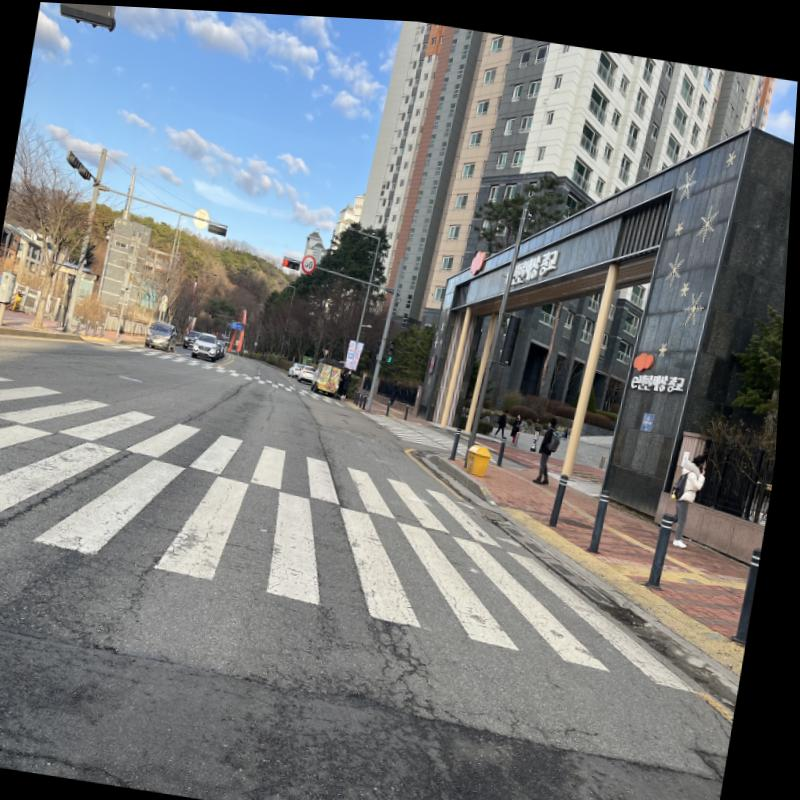

In [25]:
sample = list(data_dir.glob('*.jpg'))
PIL.Image.open(str(sample[0]))

(800, 800)


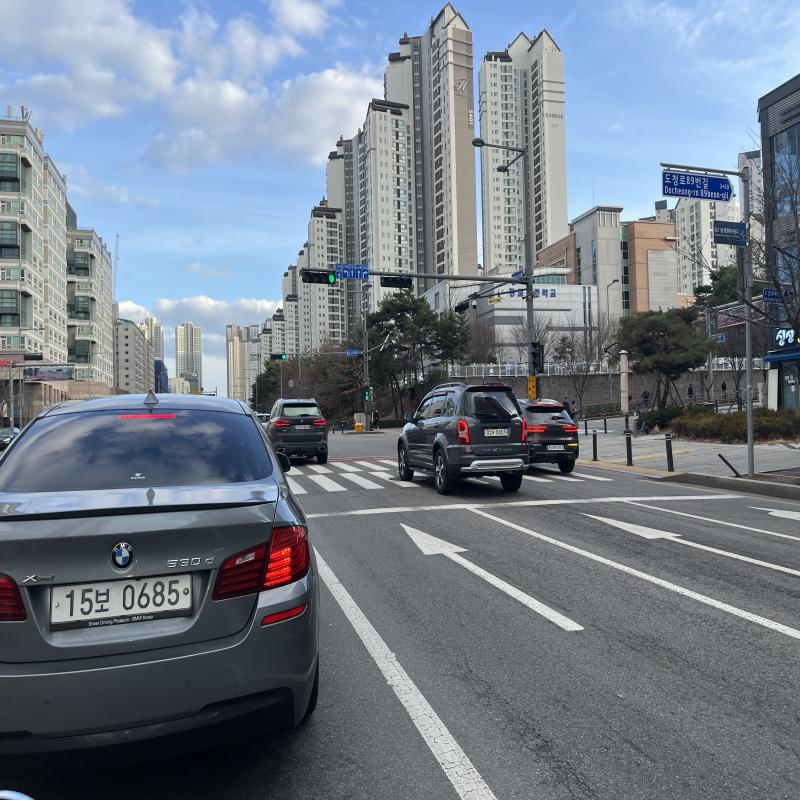

In [28]:
print(PIL.Image.open(str(sample[0])).size)
PIL.Image.open(str(sample[3]))


모든 데이터의 크기가 같은지 확인

In [31]:
is_size_same = True
for now_image in sample:
    if PIL.Image.open(str(now_image)).size != (800, 800):
        is_size_same = False
        break

print("size의 통일 여부: " ,is_size_same)

size의 통일 여부:  True
